<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.8/GP%20regression(cos).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process Regression

- predict 값과 함께 predict 값의 불확실성도 알 수 있음 ( 신뢰도 ) <br>
- cos 함수를 data로 사용해 불확실성과 예측 함께 나타내기

In [2]:
! pip install gpytorch
import math
import torch
import gpytorch 
from matplotlib import pyplot as plt
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 5.2 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=caaa27c6e9701c39b7f45ba064933c0bc8cb6d19e1ea6a2495007ce659947ae6
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


[1] Data

- cos함수로부터 data random하게 generate해 dataset 만들기

torch.Size([100])


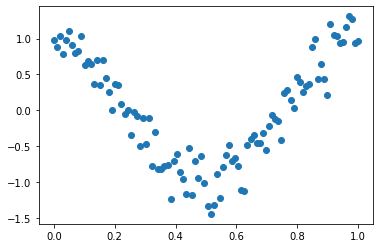

In [6]:
torch.manual_seed(1234) 
train_x = torch.linspace(0,1, 100)  # 0~1사이 수를 100등분
print(train_x.size())
train_x

train_y = torch.cos(train_x*(2*math.pi)) + torch.randn(train_x.size())*math.sqrt(0.05)
train_y.shape

plt.scatter(train_x, train_y)
plt.show()  

[2] Model

In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # mean값 구하는 module
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        # Gaussian kernel가져와서 사용

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        distribution = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return distribution

In [9]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# loss function(최적화 시 필요) : margianl log likelihood 사용
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

[3] Train

In [10]:
epoch = 50

model.train()
likelihood.train()

for i in range(epoch):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
    print('Epoch : %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, epoch, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()))

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Epoch : 1/50 - Loss: 1.002   lengthscale: 0.688   noise: 0.688
Epoch : 2/50 - Loss: 0.997   lengthscale: 0.683   noise: 0.683
Epoch : 3/50 - Loss: 0.991   lengthscale: 0.678   noise: 0.678
Epoch : 4/50 - Loss: 0.986   lengthscale: 0.673   noise: 0.673
Epoch : 5/50 - Loss: 0.980   lengthscale: 0.668   noise: 0.669
Epoch : 6/50 - Loss: 0.974   lengthscale: 0.664   noise: 0.664
Epoch : 7/50 - Loss: 0.968   lengthscale: 0.659   noise: 0.659
Epoch : 8/50 - Loss: 0.963   lengthscale: 0.654   noise: 0.654
Epoch : 9/50 - Loss: 0.957   lengthscale: 0.649   noise: 0.649
Epoch : 10/50 - Loss: 0.951   lengthscale: 0.644   noise: 0.644
Epoch : 11/50 - Loss: 0.945   lengthscale: 0.640   noise: 0.640
Epoch : 12/50 - Loss: 0.939   lengthscale: 0.635   noise: 0.635
Epoch : 13/50 - Loss: 0.933   lengthscale: 0.630   noise: 0.630
Epoch : 14/50 - Loss: 0.927   lengthscale: 0.625   noise: 0.625
Epoch : 15/50 - Loss: 0.921   lengthscale: 0.621   noise: 0.621
Epoch : 16/50 - Loss: 0.915   lengthscale: 0.616 

[4] Predict

In [12]:
model.eval()
likelihood.eval()

# TEST Model 
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 3, 51) 
    observed_pred = likelihood(model(test_x))  

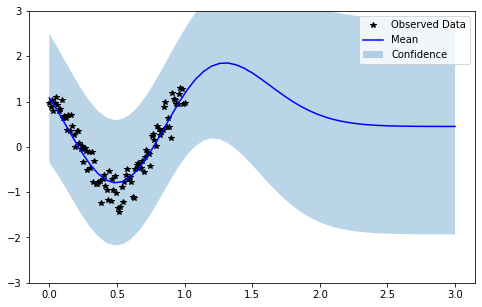

In [14]:
# 결과 plot하여 prediction과 uncertainty 확인

f, ax = plt.subplots(1, 1, figsize=(8, 5))
lower, upper = observed_pred.confidence_region()
# 실제 값
ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
# 예측값 평균
ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')

# Confidence bound (boundary를 색칠함)
ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)
ax.set_ylim([-3, 3])# y값의 범위를 [-3, 3]

ax.legend(['Observed Data', 'Mean', 'Confidence'])